# Change point detaction by knots estimation in B-Spline approach

## Library

In [1]:
import pandas as pd
import numpy as np
import random
from scipy.stats import bernoulli
from scipy.interpolate import BSpline
import patsy 
import pickle
import pystan
from pystan import StanModel

import matplotlib.pyplot as plt
%matplotlib inline

import multiprocessing
# fix issue in Python 3.9 with PyStan2
multiprocessing.set_start_method("fork")

## Create a b-spline problem and fit with known knots and values

In [57]:
def B(x, k, i, t):
    if k == 0:
        return 1.0 if t[i] <= x < t[i+1] else 0.0
    if t[i+k] == t[i]:
        c1 = 0.0
    else:
        c1 = (x - t[i])/(t[i+k] - t[i]) * B(x, k-1, i, t)
    if t[i+k+1] == t[i+1]:
        c2 = 0.0
    else:
        c2 = (t[i+k+1] - x)/(t[i+k+1] - t[i+1]) * B(x, k-1, i+1, t)
    return c1 + c2

def bspline(x, t, c, k):
    n = len(t) - k - 1
    assert (n >= k+1) and (len(c) >= n)
    return sum(c[i] * B(x, k, i, t) for i in range(n))

assuming we know the coefficients...

In [58]:
k = 2
t = [0, 1, 2, 3, 4, 5, 6]
c = [-1, 2, 0, -1]
spl = BSpline(t, c, k)
xx = np.linspace(1.5, 4.5, 50)
y = spl(xx) + np.random.normal(0, 0.1, len(xx))

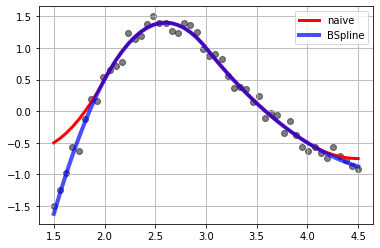

In [59]:
fig, ax = plt.subplots()
ax.plot(xx, [bspline(x, t, c ,k) for x in xx], 'r-', lw=3, label='naive')
ax.plot(xx, spl(xx), 'b-', lw=4, alpha=0.7, label='BSpline')
ax.scatter(xx, y, color='black', alpha=0.5)
ax.grid(True)
ax.legend(loc='best')
plt.show()

In [60]:
xx = np.linspace(1.5, 4.5, 50)
xx.shape

(50,)

here is an inefficient way to get splined curve and assuming we know the coefficients

In [61]:
n = len(t) - k - 1
b = np.empty((len(xx), n))
for i in range(len(xx)):
    for j in range(n):
        b[i, j] = B(xx[i], k, j, t)

In [62]:
c = np.array(c)
print(b.shape, c.shape)

(50, 4) (4,)


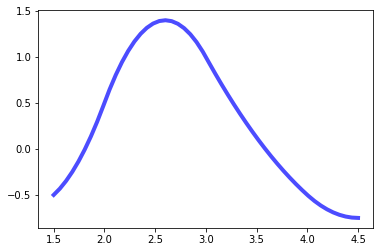

In [63]:
xx_bsplined = np.matmul(b, c)
fig, ax = plt.subplots()
ax.plot(xx, xx_bsplined, 'b-', lw=4, alpha=0.7, label='BSpline')

Let's use `patsy` to get the b-basis function and estimate coefficients in stan...

In [64]:
t = np.linspace(np.min(xx), np.max(xx), 4)
b = patsy.bs(xx, knots=t, degree=2)

In [65]:
print(b.shape)

(50, 6)


## Using B-Spline Stan Code to fit the curve

In [147]:
bspline_stan_code = """
functions {
  vector build_b_spline(real[] t, real[] ext_knots, int ind, int order);
  vector build_b_spline(real[] t, real[] ext_knots, int ind, int order) {
    // INPUTS:
    //    t:          the points at which the b_spline is calculated
    //    ext_knots:  the set of extended knots
    //    ind:        the index of the b_spline
    //    order:      the order of the b-spline
    vector[size(t)] b_spline;
    vector[size(t)] w1 = rep_vector(0, size(t));
    vector[size(t)] w2 = rep_vector(0, size(t));
    if (order==1)
      for (i in 1:size(t)) // B-splines of order 1 are piece-wise constant
        b_spline[i] = (ext_knots[ind] <= t[i]) && (t[i] < ext_knots[ind+1]);
    else {
      if (ext_knots[ind] != ext_knots[ind+order-1])
        w1 = (to_vector(t) - rep_vector(ext_knots[ind], size(t))) /
             (ext_knots[ind+order-1] - ext_knots[ind]);
      if (ext_knots[ind+1] != ext_knots[ind+order])
        w2 = 1 - (to_vector(t) - rep_vector(ext_knots[ind+1], size(t))) /
                 (ext_knots[ind+order] - ext_knots[ind+1]);
      // Calculating the B-spline recursively as linear interpolation of two lower-order splines
      b_spline = w1 .* build_b_spline(t, ext_knots, ind, order-1) +
                 w2 .* build_b_spline(t, ext_knots, ind+1, order-1);
    }
    return b_spline;
  }
}

data {
  int num_data;             // number of data points
  int num_knots;            // num of knots
  vector[num_knots] knots;  // the sequence of knots
  int spline_degree;        // the degree of spline (is equal to order - 1)
  real Y[num_data];
  real X[num_data];
}

transformed data {
  int num_basis = num_knots + spline_degree - 1; // total number of B-splines
  matrix[num_basis, num_data] B;  // matrix of B-splines
  vector[spline_degree + num_knots] ext_knots_temp;
  vector[2*spline_degree + num_knots] ext_knots; // set of extended knots
  ext_knots_temp = append_row(rep_vector(knots[1], spline_degree), knots);
  ext_knots = append_row(ext_knots_temp, rep_vector(knots[num_knots], spline_degree));
  for (ind in 1:num_basis)
    B[ind,:] = to_row_vector(build_b_spline(X, to_array_1d(ext_knots), ind, spline_degree + 1));
  B[num_knots + spline_degree - 1, num_data] = 1;
}

parameters {
  row_vector[num_basis] a_raw;
  real a0;  // intercept
  real<lower=0> sigma;
  real<lower=0> tau;
}

// unpenalized version
// transformed parameters {
//  row_vector[num_basis] a; // spline coefficients
//  vector[num_data] Y_hat;
//  a = a_raw*tau;
//  Y_hat = a0*to_vector(X) + to_vector(a*B);
//}

transformed parameters {
  row_vector[num_basis] a;
  vector[num_data] Y_hat;
  a[1] = a_raw[1];
  for (i in 2:num_basis)
    a[i] = a[i-1] + a_raw[i]*tau;
  Y_hat = a0*to_vector(X) + to_vector(a*B);
}


model {
  // Priors
  a_raw ~ normal(0, 1);
  a0 ~ normal(0, 1);
  tau ~ normal(0, 1);
  sigma ~ normal(0, 1);

  //Likelihood
  Y ~ normal(Y_hat, sigma);
}

"""
sm = pystan.StanModel(model_code=bspline_stan_code)
with open('../models/cp_stan.pkl', 'wb') as f:
    pickle.dump(sm, f)
# with open('../models/cp_stan.pkl', 'rb') as f:
#     sm = pickle.load(f)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_887fd1ee4619c083133779a91bb86a7a NOW.
In file included from /var/folders/9f/m35pbwgx13n2j29rjhpkcyg40000gn/T/pystan_n7iclzop/stanfit4anon_model_887fd1ee4619c083133779a91bb86a7a_6464039022049658020.cpp:709:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/numpy/core/include/numpy/ndarraytypes.h:1969:
/Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it with " \
 ^
In file included from /var/fold

In file included from /var/folders/9f/m35pbwgx13n2j29rjhpkcyg40000gn/T/pystan_n7iclzop/stanfit4anon_model_887fd1ee4619c083133779a91bb86a7a_6464039022049658020.cpp:718:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/

In file included from /var/folders/9f/m35pbwgx13n2j29rjhpkcyg40000gn/T/pystan_n7iclzop/stanfit4anon_model_887fd1ee4619c083133779a91bb86a7a_6464039022049658020.cpp:718:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/

In file included from /var/folders/9f/m35pbwgx13n2j29rjhpkcyg40000gn/T/pystan_n7iclzop/stanfit4anon_model_887fd1ee4619c083133779a91bb86a7a_6464039022049658020.cpp:719:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan_fit.hpp:15:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/additive_combine.hpp:27:
/Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/linear_congruential.hpp:140:20: warning: overlapping comparisons always evaluate to false [-Wtautological-overlap-compare]
        if(_x <= 0 && _x != 0) {
           ~~~~~~~~^~~~~~~~~~
/Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/linear_congruential.hpp:393:11: note: in instantiation of member function 'boost::random::linear_congruential_engine<unsigned

In file included from /var/folders/9f/m35pbwgx13n2j29rjhpkcyg40000gn/T/pystan_n7iclzop/stanfit4anon_model_887fd1ee4619c083133779a91bb86a7a_6464039022049658020.cpp:718:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/

In file included from /var/folders/9f/m35pbwgx13n2j29rjhpkcyg40000gn/T/pystan_n7iclzop/stanfit4anon_model_887fd1ee4619c083133779a91bb86a7a_6464039022049658020.cpp:718:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/

/Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/src/Core/AssignEvaluator.h:879:5: note: in instantiation of function template specialization 'Eigen::internal::call_dense_assignment_loop<Eigen::Matrix<double, -1, 1, 0>, Eigen::CwiseUnaryOp<Eigen::internal::scalar_exp_op<double>, const Eigen::CwiseBinaryOp<Eigen::internal::scalar_difference_op<double>, const Eigen::ArrayWrapper<const Eigen::Matrix<double, -1, 1, 0>>, const Eigen::CwiseNullaryOp<Eigen::internal::scalar_constant_op<double>, const Eigen::Array<double, -1, 1, 0>>>>, Eigen::internal::assign_op<double, double>>' requested here
    call_dense_assignment_loop(dst, src, func);
    ^
/Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/src/Core/AssignEvaluator.h:836:46: note: in instantiation of member function 'Eigen::internal::Assignment<Eigen::Matrix<double, -1, 1, 0>, Eigen::CwiseUnaryOp<Eigen::internal:

In file included from /var/folders/9f/m35pbwgx13n2j29rjhpkcyg40000gn/T/pystan_n7iclzop/stanfit4anon_model_887fd1ee4619c083133779a91bb86a7a_6464039022049658020.cpp:718:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/

In file included from /var/folders/9f/m35pbwgx13n2j29rjhpkcyg40000gn/T/pystan_n7iclzop/stanfit4anon_model_887fd1ee4619c083133779a91bb86a7a_6464039022049658020.cpp:718:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/

In file included from /var/folders/9f/m35pbwgx13n2j29rjhpkcyg40000gn/T/pystan_n7iclzop/stanfit4anon_model_887fd1ee4619c083133779a91bb86a7a_6464039022049658020.cpp:718:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/

In file included from /var/folders/9f/m35pbwgx13n2j29rjhpkcyg40000gn/T/pystan_n7iclzop/stanfit4anon_model_887fd1ee4619c083133779a91bb86a7a_6464039022049658020.cpp:718:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/

/Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/src/Core/AssignEvaluator.h:836:46: note: in instantiation of member function 'Eigen::internal::Assignment<Eigen::Matrix<stan::math::var, 1, -1, 1>, Eigen::Map<Eigen::Matrix<stan::math::var, 1, -1, 1>, 0>, Eigen::internal::assign_op<stan::math::var, stan::math::var>, Eigen::internal::Dense2Dense>::run' requested here
  Assignment<ActualDstTypeCleaned,Src,Func>::run(actualDst, src, func);
                                             ^
/Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/src/Core/PlainObjectBase.h:728:17: note: in instantiation of function template specialization 'Eigen::internal::call_assignment_no_alias<Eigen::Matrix<stan::math::var, 1, -1, 1>, Eigen::Map<Eigen::Matrix<stan::math::var, 1, -1, 1>, 0>, Eigen::internal::assign_op<stan::math::var, stan::math::var>>' requested here
      internal::call_as

In file included from /var/folders/9f/m35pbwgx13n2j29rjhpkcyg40000gn/T/pystan_n7iclzop/stanfit4anon_model_887fd1ee4619c083133779a91bb86a7a_6464039022049658020.cpp:718:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/

In file included from /var/folders/9f/m35pbwgx13n2j29rjhpkcyg40000gn/T/pystan_n7iclzop/stanfit4anon_model_887fd1ee4619c083133779a91bb86a7a_6464039022049658020.cpp:718:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/

167 warnings generated.


FileNotFoundError: [Errno 2] No such file or directory: '../models/cp_stan.pkl'

Let's say we didn't know the true number of knots and assume some smaller number of knots.

In [81]:
knots = np.quantile(xx, np.arange(0, 1, 1/10))

In [82]:
input_data = {
    'num_data': len(xx),
    'num_knots':len(knots),
    'knots': knots,
    'spline_degree': 3,
    'Y': y,
    'X': xx,
#     'B': b.transpose(),
}

In [83]:
fit = sm.sampling(data=input_data)
yhat = fit['Y_hat']
c0 = fit['a0']
c = fit['a']


Gradient evaluation took 8.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.84 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)

Gradient evaluation took 8.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.86 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 7.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.76 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)

Gradient evaluation took 0.000146 seconds
1000 transitions using 10 leapfrog steps per transition would take 1.46 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20

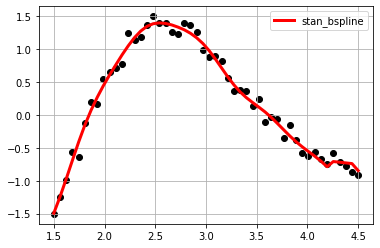

In [87]:
fig, ax = plt.subplots()
ax.plot(xx, np.median(yhat, 0), 'r-', lw=3, label='stan_bspline')
ax.scatter(xx, y, color='black')
ax.grid(True)
ax.legend(loc='best')
plt.show()

## Revisit the kernel and change point problem with B-Spline Stan code fitting

In [148]:
def sandwich_kernel(x, x_i):
    """
    x: points required to compute kernel weight
    x_i: reference points location used to compute correspondent distance of each entry points
    return:
        a matrix with N x M such that
        N as the number of entry points
        M as the number of reference points
        matrix entries hold the value of weight of each element
    see also:
      1. https://mc-stan.org/docs/2_24/stan-users-guide/gaussian-process-regression.html
      2. https://en.wikipedia.org/wiki/Local_regression
    """
    N = len(x)
    M = len(x_i)
    k = np.zeros((N, M), dtype=np.double)

    np_idx = np.where(x < x_i[0])
    k[np_idx, 0] = 1

    for m in range(M - 1):
        np_idx = np.where(np.logical_and(x >= x_i[m], x < x_i[m + 1]))
        total_dist = x_i[m + 1] - x_i[m]
        backward_dist = x[np_idx] - x_i[m]
        forward_dist = x_i[m + 1] - x[np_idx]
        k[np_idx, m] = forward_dist / total_dist
        k[np_idx, m + 1] = backward_dist / total_dist

    np_idx = np.where(x >= x_i[M - 1])
    k[np_idx, M - 1] = 1

    # TODO: it is probably not needed
    k = k / np.sum(k, axis=1, keepdims=True)

    return k

In [149]:
T = 365 * 3
# just an initial guess
N_KNOTS = 36
np.random.seed(2021)

In [150]:
noise = np.random.normal(0, 0.5, T)

In [151]:
is_jump = (np.random.uniform(0, 1, N_KNOTS) > 0.8).astype(np.int32)
is_jump

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [152]:
jump_size = np.random.normal(0, 3, N_KNOTS) 

In [153]:
knots = np.cumsum(is_jump * jump_size)

In [154]:
# normalize time
width = 1/len(knots)
tp = np.arange(1, T + 1)/ T
knots_tp = np.arange(width/2, 1, width)

In [155]:
K = sandwich_kernel(tp, knots_tp)

In [156]:
print(K.shape, knots.shape)

(1095, 36) (36,)


In [157]:
trend = np.matmul(K, knots)
y = trend + noise

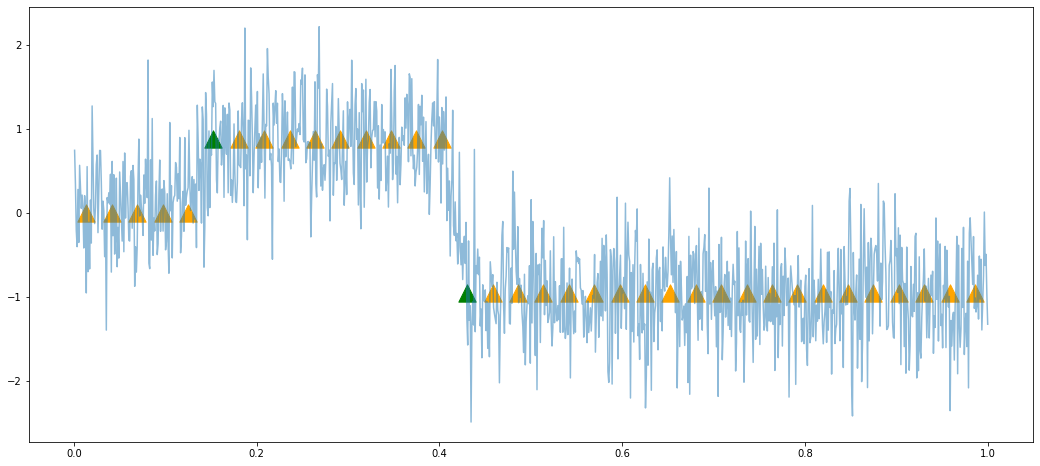

In [158]:
fig, ax = plt.subplots(1, 1, figsize=(18, 8))
ax.plot(tp, y, alpha=0.5)
ax.scatter(knots_tp[is_jump>0], knots[is_jump>0], marker='^', s=300, color='green');
ax.scatter(knots_tp[is_jump==0], knots[is_jump==0], marker='^', s=300, color='orange');

Question here: can we create a pyro to connect the knots?

In [159]:
input_data = {
    'num_data': len(tp),
    'num_knots': len(knots_tp),
    'knots': knots_tp,
    'spline_degree': 3,
    'Y': y,
    'X': tp,
}

In [162]:
fit = sm.sampling(data=input_data)
yhat = fit['Y_hat']
c0 = fit['a0']
c = fit['a']


Gradient evaluation took 0.000712 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.12 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000628 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.28 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000582 seconds
1000 transitions using 10 leapfrog steps per transition would take 5.82 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000593 seconds
1000 transitions using 10 leapfrog steps per transition would take 5.93 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 45.2388 seconds (Warm-up)
               54.6838 seconds (Sampling)
               99.9226 seconds (Total)



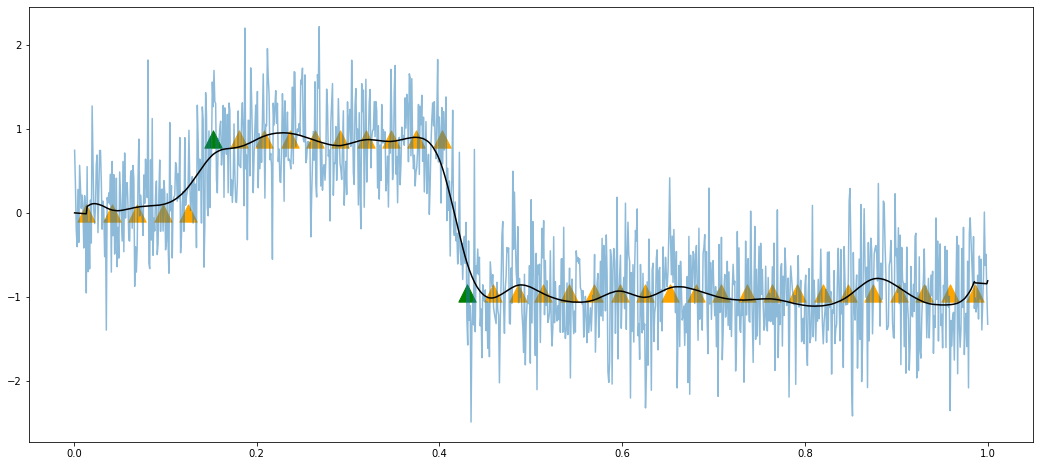

In [161]:
fig, ax = plt.subplots(1, 1, figsize=(18, 8))
ax.plot(tp, y, alpha=0.5)
ax.scatter(knots_tp[is_jump>0], knots[is_jump>0], marker='^', s=300, color='green')
ax.scatter(knots_tp[is_jump==0], knots[is_jump==0], marker='^', s=300, color='orange')
ax.plot(tp, np.median(yhat, 0), label='fitted', color='black');

## Try a naive mean and stepwise stan model

In [251]:
compiled_model = pystan.StanModel("./stan/naive_change_point.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0a7d39f8b8002ca69968cb06cd7f22fb NOW.
In file included from /var/folders/9f/m35pbwgx13n2j29rjhpkcyg40000gn/T/pystan_a_3xv4j5/stanfit4anon_model_0a7d39f8b8002ca69968cb06cd7f22fb_3021925574709480987.cpp:709:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/numpy/core/include/numpy/ndarraytypes.h:1969:
/Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it with " \
 ^
In file included from /var/fold

In file included from /var/folders/9f/m35pbwgx13n2j29rjhpkcyg40000gn/T/pystan_a_3xv4j5/stanfit4anon_model_0a7d39f8b8002ca69968cb06cd7f22fb_3021925574709480987.cpp:718:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/

In file included from /var/folders/9f/m35pbwgx13n2j29rjhpkcyg40000gn/T/pystan_a_3xv4j5/stanfit4anon_model_0a7d39f8b8002ca69968cb06cd7f22fb_3021925574709480987.cpp:718:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/

In file included from /var/folders/9f/m35pbwgx13n2j29rjhpkcyg40000gn/T/pystan_a_3xv4j5/stanfit4anon_model_0a7d39f8b8002ca69968cb06cd7f22fb_3021925574709480987.cpp:719:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan_fit.hpp:15:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/additive_combine.hpp:27:
/Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/linear_congruential.hpp:140:20: warning: overlapping comparisons always evaluate to false [-Wtautological-overlap-compare]
        if(_x <= 0 && _x != 0) {
           ~~~~~~~~^~~~~~~~~~
/Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/linear_congruential.hpp:393:11: note: in instantiation of member function 'boost::random::linear_congruential_engine<unsigned

/Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/src/Core/PlainObjectBase.h:728:17: note: in instantiation of function template specialization 'Eigen::internal::call_assignment_no_alias<Eigen::Matrix<double, -1, -1, 1>, Eigen::Matrix<double, -1, -1, 1>, Eigen::internal::assign_op<double, double>>' requested here
      internal::call_assignment_no_alias(this->derived(), other.derived(), internal::assign_op<Scalar,typename OtherDerived::Scalar>());
                ^
/Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/src/Core/Matrix.h:278:15: note: in instantiation of function template specialization 'Eigen::PlainObjectBase<Eigen::Matrix<double, -1, -1, 1>>::_set_noalias<Eigen::Matrix<double, -1, -1, 1>>' requested here
        Base::_set_noalias(other);
              ^
/Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/lib/e

In file included from /var/folders/9f/m35pbwgx13n2j29rjhpkcyg40000gn/T/pystan_a_3xv4j5/stanfit4anon_model_0a7d39f8b8002ca69968cb06cd7f22fb_3021925574709480987.cpp:718:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/

In file included from /var/folders/9f/m35pbwgx13n2j29rjhpkcyg40000gn/T/pystan_a_3xv4j5/stanfit4anon_model_0a7d39f8b8002ca69968cb06cd7f22fb_3021925574709480987.cpp:718:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/

In file included from /var/folders/9f/m35pbwgx13n2j29rjhpkcyg40000gn/T/pystan_a_3xv4j5/stanfit4anon_model_0a7d39f8b8002ca69968cb06cd7f22fb_3021925574709480987.cpp:718:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/

In file included from /var/folders/9f/m35pbwgx13n2j29rjhpkcyg40000gn/T/pystan_a_3xv4j5/stanfit4anon_model_0a7d39f8b8002ca69968cb06cd7f22fb_3021925574709480987.cpp:718:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/

In file included from /var/folders/9f/m35pbwgx13n2j29rjhpkcyg40000gn/T/pystan_a_3xv4j5/stanfit4anon_model_0a7d39f8b8002ca69968cb06cd7f22fb_3021925574709480987.cpp:718:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/

In file included from /var/folders/9f/m35pbwgx13n2j29rjhpkcyg40000gn/T/pystan_a_3xv4j5/stanfit4anon_model_0a7d39f8b8002ca69968cb06cd7f22fb_3021925574709480987.cpp:718:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/

In file included from /var/folders/9f/m35pbwgx13n2j29rjhpkcyg40000gn/T/pystan_a_3xv4j5/stanfit4anon_model_0a7d39f8b8002ca69968cb06cd7f22fb_3021925574709480987.cpp:718:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/

In file included from /var/folders/9f/m35pbwgx13n2j29rjhpkcyg40000gn/T/pystan_a_3xv4j5/stanfit4anon_model_0a7d39f8b8002ca69968cb06cd7f22fb_3021925574709480987.cpp:718:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/

In file included from /var/folders/9f/m35pbwgx13n2j29rjhpkcyg40000gn/T/pystan_a_3xv4j5/stanfit4anon_model_0a7d39f8b8002ca69968cb06cd7f22fb_3021925574709480987.cpp:718:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/edwinng/work/venv/ts-research/lib/python3.9/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/

153 warnings generated.


In [254]:
input_data = {
    'num_data': len(y),
    'num_knots': 3,
    'y': y,
    'sd_y': np.std(y),
}

In [255]:
fit = compiled_model.sampling(data=input_data)


Gradient evaluation took 7.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.79 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000121 seconds
1000 transitions using 10 leapfrog steps per transition would take 1.21 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)

Gradient evaluation took 8.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.86 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)

Gradient evaluation took 8.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.83 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [256]:
posteriors = fit.extract(
    permuted=True
)
yhat = posteriors['yhat']

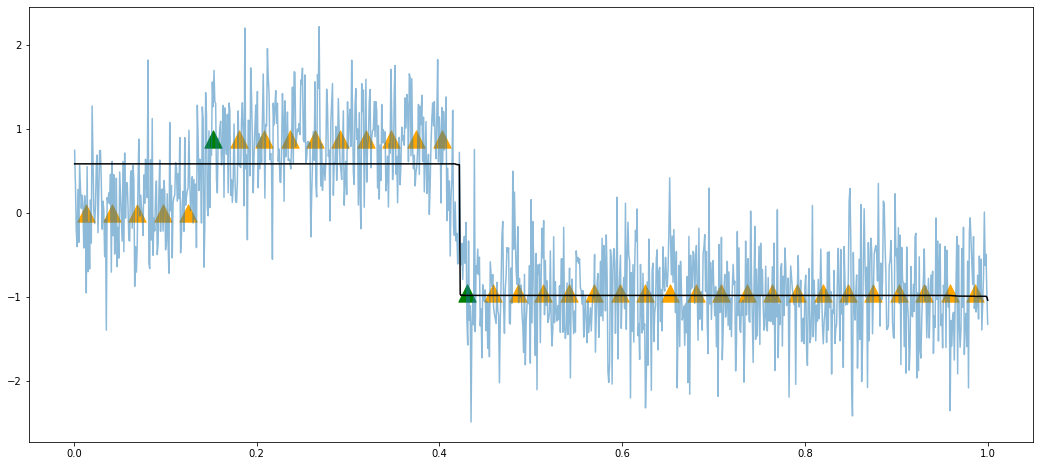

In [245]:
fig, ax = plt.subplots(1, 1, figsize=(18, 8))
ax.plot(tp, y, alpha=0.5)
ax.scatter(knots_tp[is_jump>0], knots[is_jump>0], marker='^', s=300, color='green')
ax.scatter(knots_tp[is_jump==0], knots[is_jump==0], marker='^', s=300, color='orange')
ax.plot(tp, np.median(yhat, 0), label='fitted', color='black');

In [246]:
np.median(posteriors['alpha'], 0)

array([ 0.58305087, -1.41310145, -0.9583554 , -1.0403483 ])